<a href="https://colab.research.google.com/github/Hyeseong0317/Pytorch_Capstone_Design/blob/main/ResNet18_Adam_shortened2_30batch_60epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import copy
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(777)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=4):
        super(ResNet, self).__init__()
        self.in_planes = 64

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224),                         
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224),                        
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

In [ ]:
data_dir = '/content/drive/Shareddrives/8:1:1_shortened2/OCT2017(8:1:1)shortened2'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                    for x in ['train', 'val', 'test']}


In [ ]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
                                             shuffle=True, drop_last=True, num_workers=4)
                    for x in ['train', 'val', 'test']}
        
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


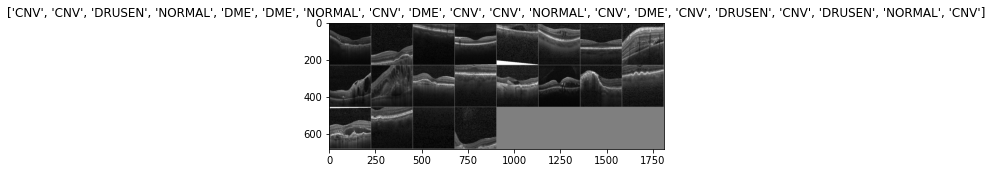

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
for id, data in enumerate(dataloaders['train']):
  print(id)
  img = data[0]
  label = data[1]
  print(img.shape)
  print(label.shape)
  break

0
torch.Size([20, 1, 224, 224])
torch.Size([20])


In [ ]:
inputs = torch.Tensor(20, 1, 224, 224)
print('텐서의 크기 : {}'.format(inputs.shape))

텐서의 크기 : torch.Size([20, 1, 224, 224])


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=60):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses = []
    train_accuracies = []

    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
              train_losses.append(epoch_loss)
              train_accuracies.append(epoch_acc)

            if phase == 'val':
              val_losses.append(epoch_loss)
              val_accuracies.append(epoch_acc)

            # 1 epoch 마다 loss 출력
            x_train_losses = np.arange(len(train_losses))
            x_val_losses = np.arange(len(val_losses))
            plt.plot(x_train_losses, train_losses)
            plt.plot(x_val_losses, val_losses)            
            plt.xlabel('epochs')
            plt.ylabel('loss')
            plt.title('loss per epoch')
            plt.legend(['train', 'val'])
            plt.show()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)

    return model, train_losses, train_accuracies, val_losses, val_accuracies # 5개의 변수를 반환

In [ ]:
model_ft = ResNet18()

#os.chdir('/content/drive/Shareddrives/ResNet18_Model_parameters')
# Present working directory
#!pwd
#PATH = 'ResNet18_retina.pth'->파일명에 따라서 다른이름으로 수정하여저장
# 학습된 모델 파라미터 로드
#model_ft.load_state_dict(torch.load(PATH))

In [ ]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/59
----------


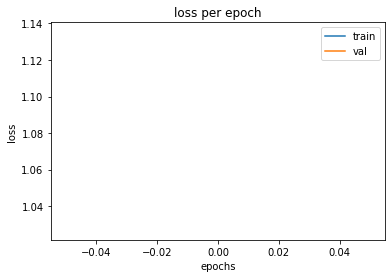

train Loss: 1.0811 Acc: 0.5270


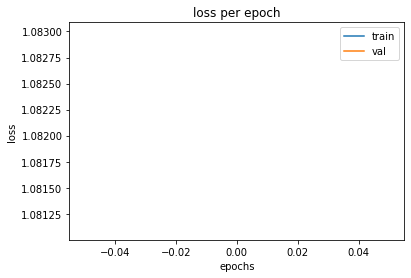

val Loss: 1.0830 Acc: 0.5421

Epoch 1/59
----------


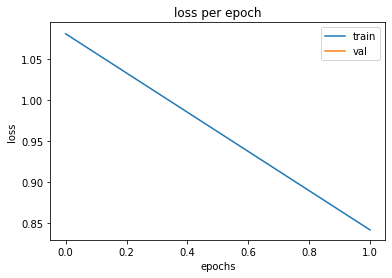

train Loss: 0.8415 Acc: 0.6577


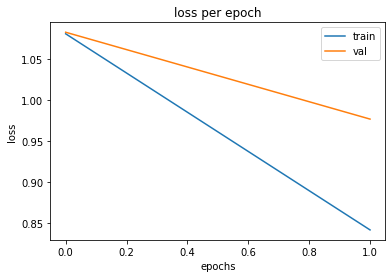

val Loss: 0.9769 Acc: 0.6638

Epoch 2/59
----------


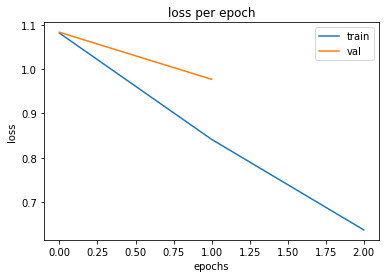

train Loss: 0.6374 Acc: 0.7473


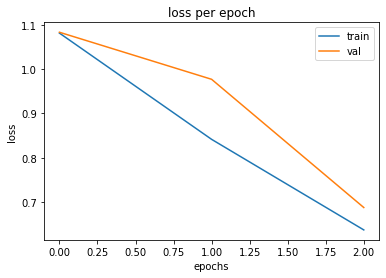

val Loss: 0.6878 Acc: 0.7479

Epoch 3/59
----------


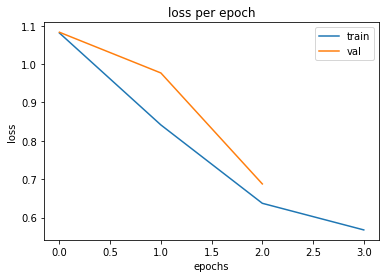

train Loss: 0.5680 Acc: 0.7776


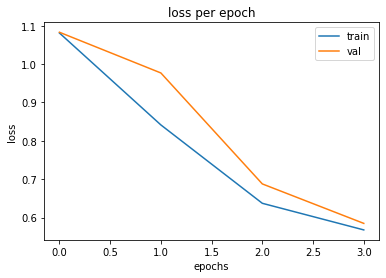

val Loss: 0.5850 Acc: 0.7821

Epoch 4/59
----------


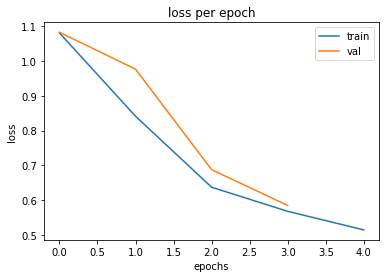

train Loss: 0.5146 Acc: 0.8015


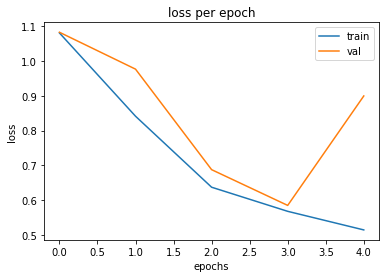

val Loss: 0.8998 Acc: 0.6588

Epoch 5/59
----------


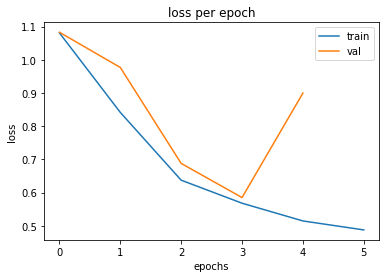

train Loss: 0.4875 Acc: 0.8095


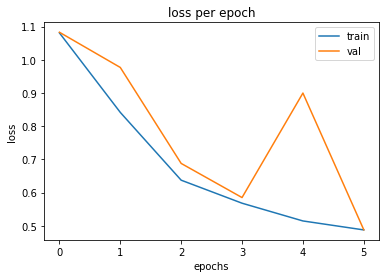

val Loss: 0.4879 Acc: 0.8138

Epoch 6/59
----------


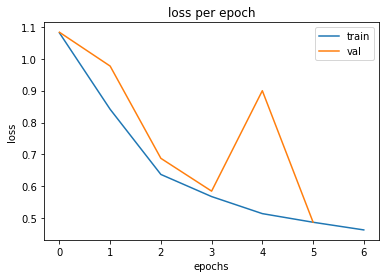

train Loss: 0.4635 Acc: 0.8204


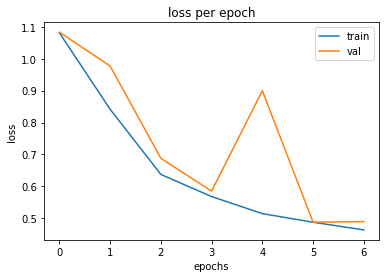

val Loss: 0.4895 Acc: 0.8175

Epoch 7/59
----------


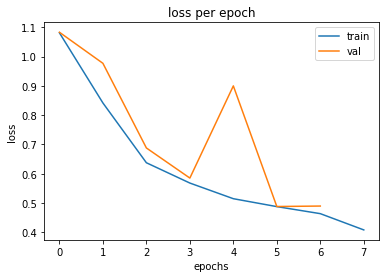

train Loss: 0.4080 Acc: 0.8433


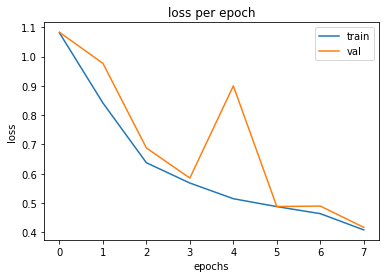

val Loss: 0.4166 Acc: 0.8329

Epoch 8/59
----------


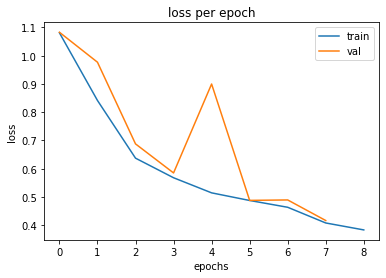

train Loss: 0.3834 Acc: 0.8536


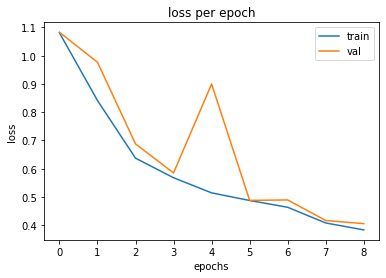

val Loss: 0.4056 Acc: 0.8333

Epoch 9/59
----------


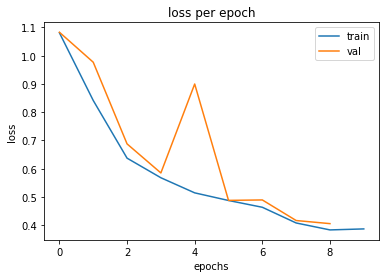

train Loss: 0.3869 Acc: 0.8511


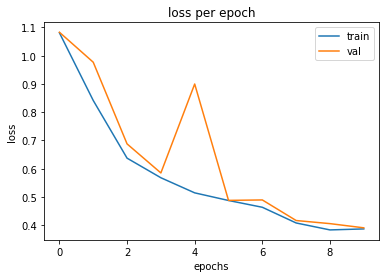

val Loss: 0.3908 Acc: 0.8471

Epoch 10/59
----------


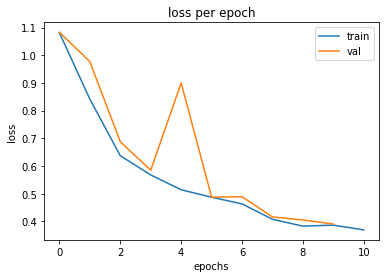

train Loss: 0.3696 Acc: 0.8577


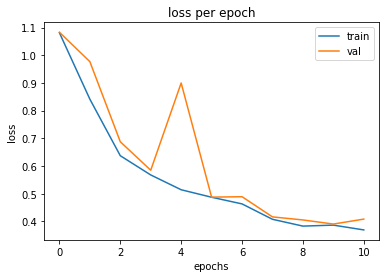

val Loss: 0.4086 Acc: 0.8313

Epoch 11/59
----------


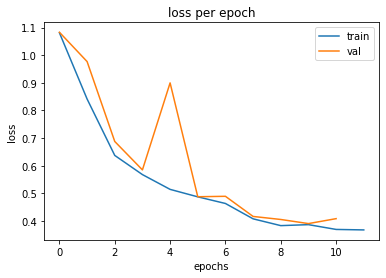

train Loss: 0.3679 Acc: 0.8587


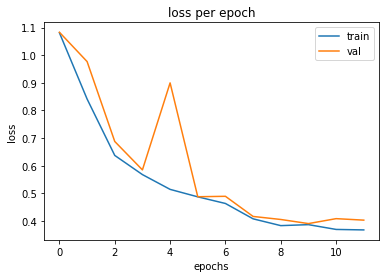

val Loss: 0.4032 Acc: 0.8492

Epoch 12/59
----------


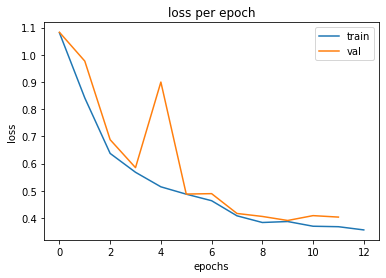

train Loss: 0.3561 Acc: 0.8630


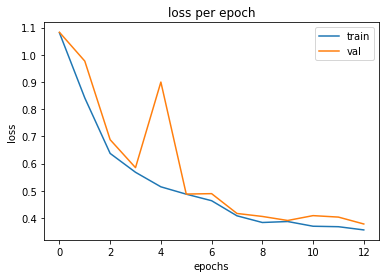

val Loss: 0.3779 Acc: 0.8458

Epoch 13/59
----------


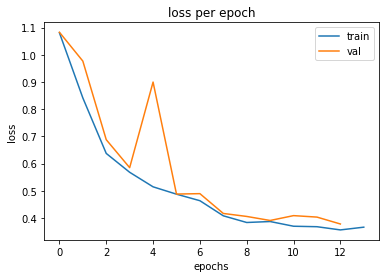

train Loss: 0.3662 Acc: 0.8600


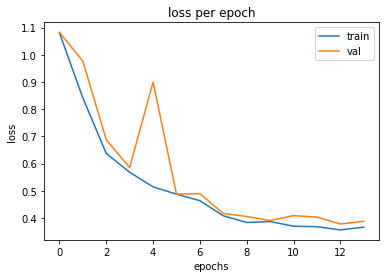

val Loss: 0.3878 Acc: 0.8479

Epoch 14/59
----------


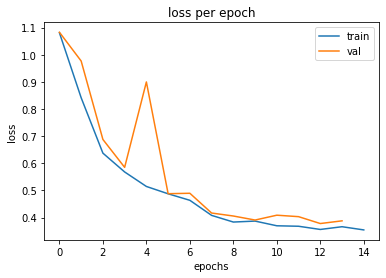

train Loss: 0.3544 Acc: 0.8661


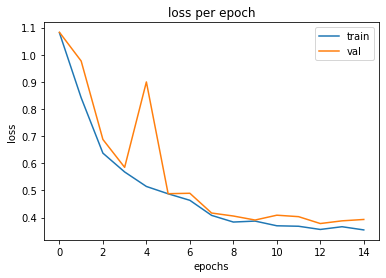

val Loss: 0.3929 Acc: 0.8463

Epoch 15/59
----------


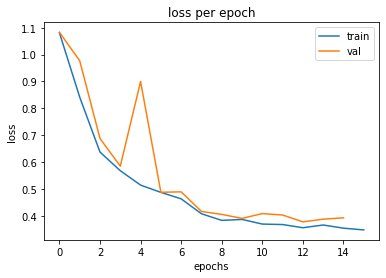

train Loss: 0.3479 Acc: 0.8680


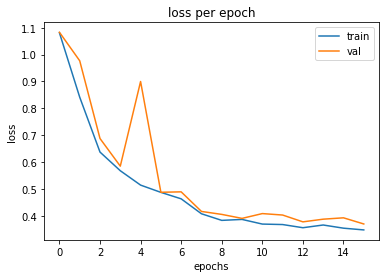

val Loss: 0.3700 Acc: 0.8496

Epoch 16/59
----------


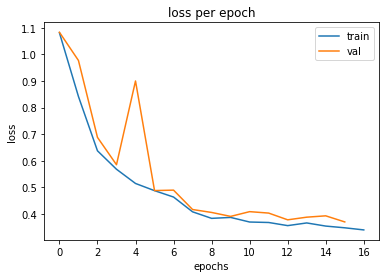

train Loss: 0.3399 Acc: 0.8709


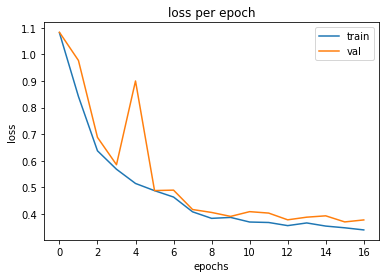

val Loss: 0.3775 Acc: 0.8429

Epoch 17/59
----------


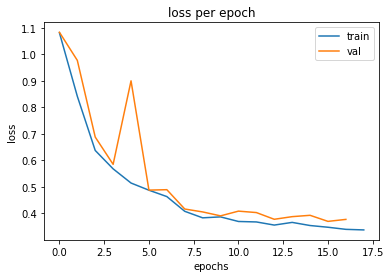

train Loss: 0.3378 Acc: 0.8694


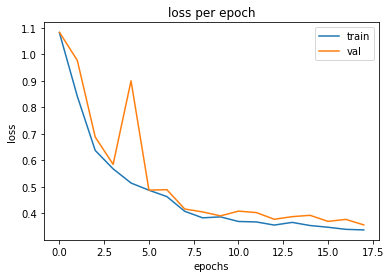

val Loss: 0.3567 Acc: 0.8538

Epoch 18/59
----------


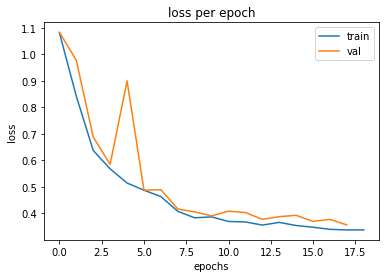

train Loss: 0.3380 Acc: 0.8697


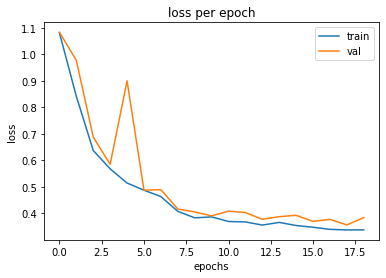

val Loss: 0.3843 Acc: 0.8429

Epoch 19/59
----------


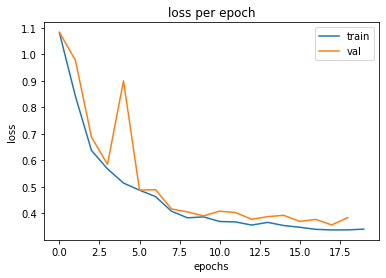

train Loss: 0.3408 Acc: 0.8699


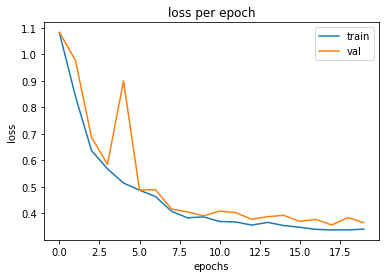

val Loss: 0.3649 Acc: 0.8546

Epoch 20/59
----------


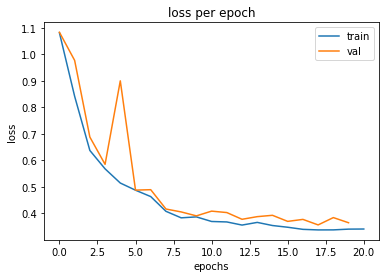

train Loss: 0.3412 Acc: 0.8687


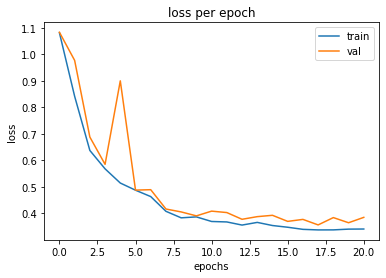

val Loss: 0.3851 Acc: 0.8454

Epoch 21/59
----------


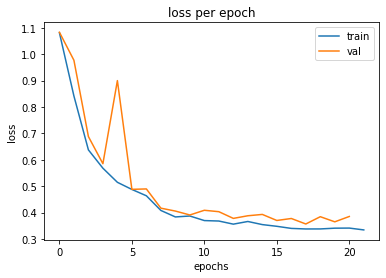

train Loss: 0.3342 Acc: 0.8702


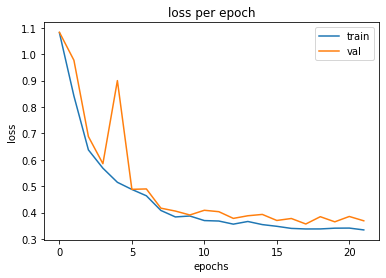

val Loss: 0.3687 Acc: 0.8558

Epoch 22/59
----------


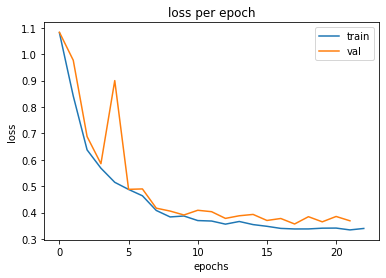

train Loss: 0.3397 Acc: 0.8693


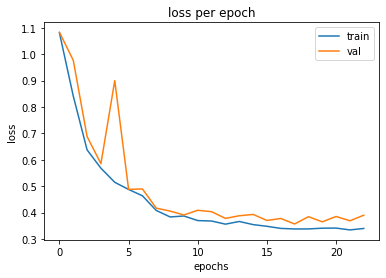

val Loss: 0.3900 Acc: 0.8492

Epoch 23/59
----------


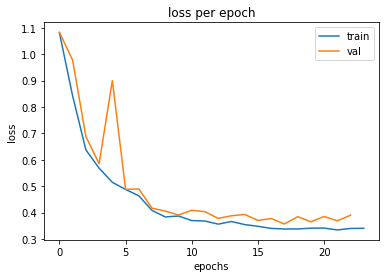

train Loss: 0.3403 Acc: 0.8687


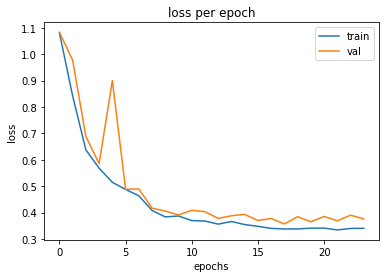

val Loss: 0.3759 Acc: 0.8542

Epoch 24/59
----------


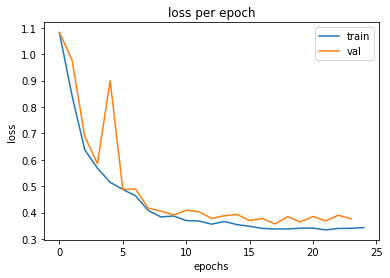

train Loss: 0.3428 Acc: 0.8688


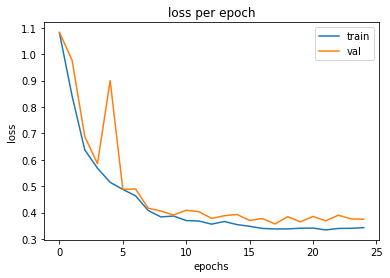

val Loss: 0.3748 Acc: 0.8500

Epoch 25/59
----------


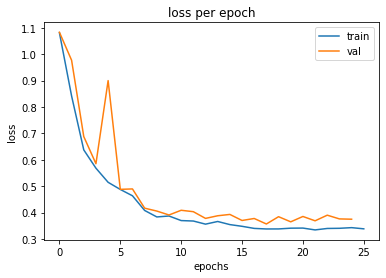

train Loss: 0.3383 Acc: 0.8710


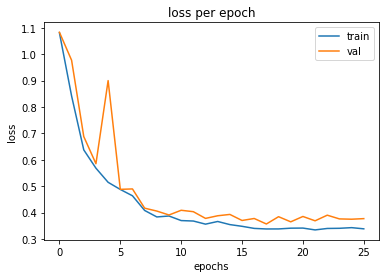

val Loss: 0.3770 Acc: 0.8517

Epoch 26/59
----------


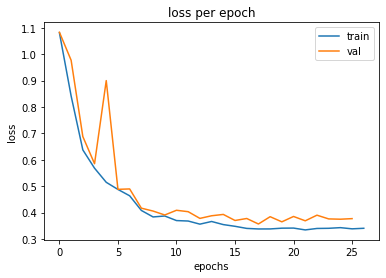

train Loss: 0.3404 Acc: 0.8701


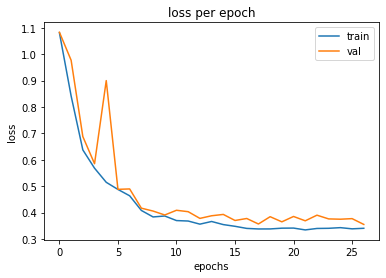

val Loss: 0.3550 Acc: 0.8579

Epoch 27/59
----------


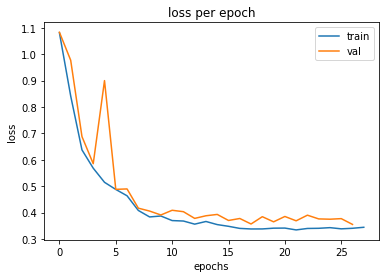

train Loss: 0.3442 Acc: 0.8667


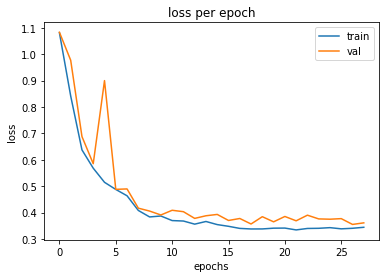

val Loss: 0.3610 Acc: 0.8638

Epoch 28/59
----------


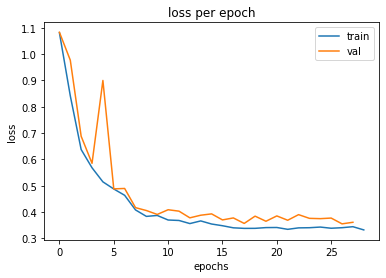

train Loss: 0.3320 Acc: 0.8744


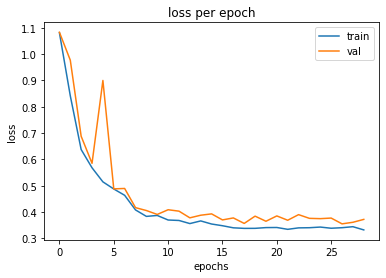

val Loss: 0.3720 Acc: 0.8575

Epoch 29/59
----------


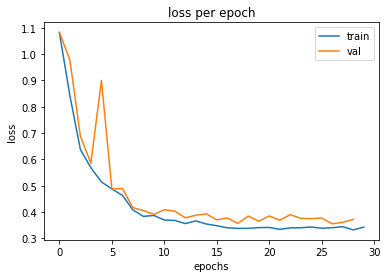

train Loss: 0.3427 Acc: 0.8692


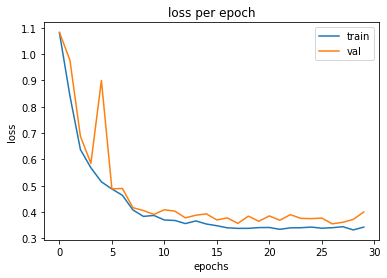

val Loss: 0.4003 Acc: 0.8400

Epoch 30/59
----------


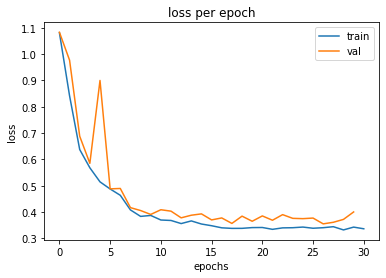

train Loss: 0.3363 Acc: 0.8712


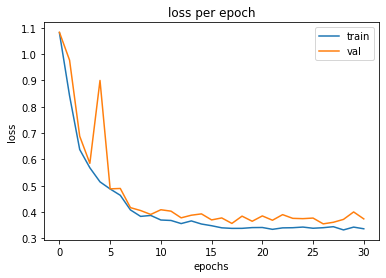

val Loss: 0.3738 Acc: 0.8550

Epoch 31/59
----------


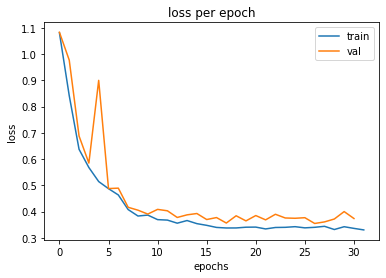

train Loss: 0.3305 Acc: 0.8726


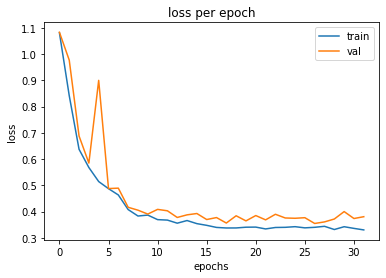

val Loss: 0.3808 Acc: 0.8429

Epoch 32/59
----------


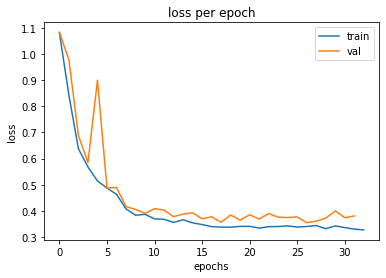

train Loss: 0.3274 Acc: 0.8735


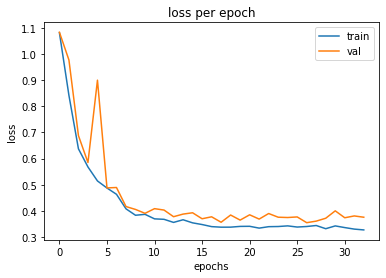

val Loss: 0.3759 Acc: 0.8579

Epoch 33/59
----------


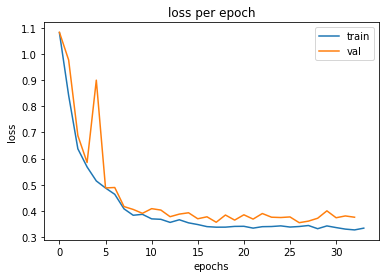

train Loss: 0.3341 Acc: 0.8726


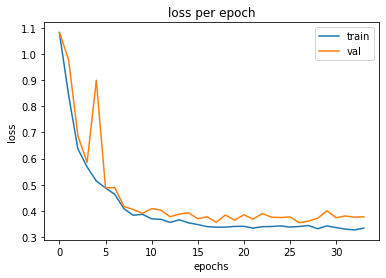

val Loss: 0.3776 Acc: 0.8567

Epoch 34/59
----------


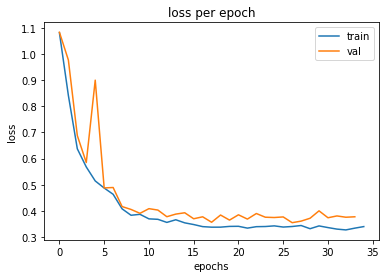

train Loss: 0.3401 Acc: 0.8709


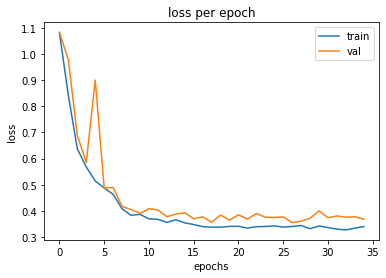

val Loss: 0.3681 Acc: 0.8521

Epoch 35/59
----------


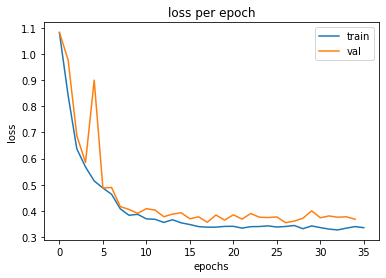

train Loss: 0.3358 Acc: 0.8724


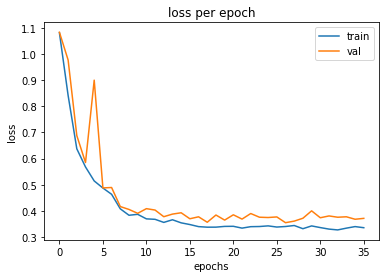

val Loss: 0.3715 Acc: 0.8529

Epoch 36/59
----------


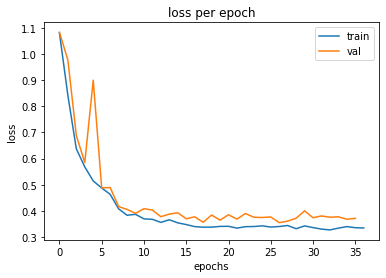

train Loss: 0.3348 Acc: 0.8697


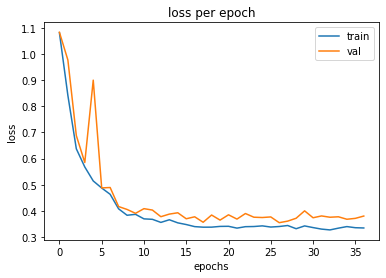

val Loss: 0.3804 Acc: 0.8488

Epoch 37/59
----------


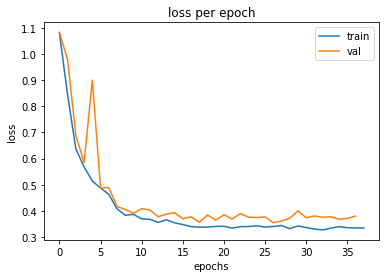

train Loss: 0.3349 Acc: 0.8700


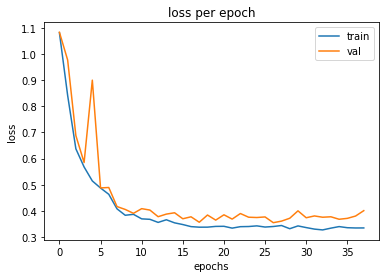

val Loss: 0.4010 Acc: 0.8304

Epoch 38/59
----------


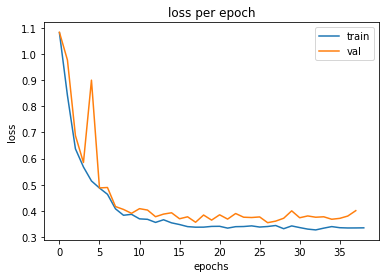

train Loss: 0.3353 Acc: 0.8705


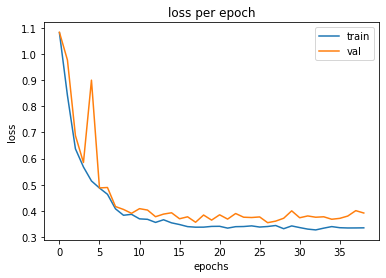

val Loss: 0.3920 Acc: 0.8429

Epoch 39/59
----------


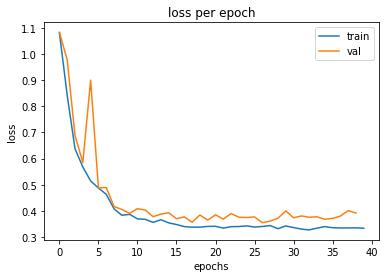

train Loss: 0.3337 Acc: 0.8720


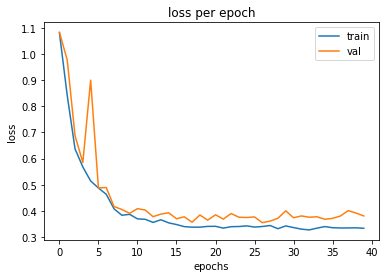

val Loss: 0.3807 Acc: 0.8500

Epoch 40/59
----------


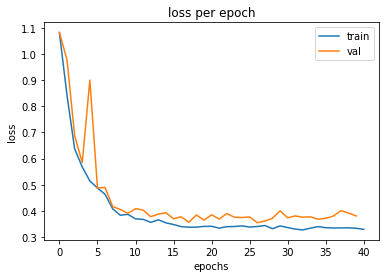

train Loss: 0.3294 Acc: 0.8732


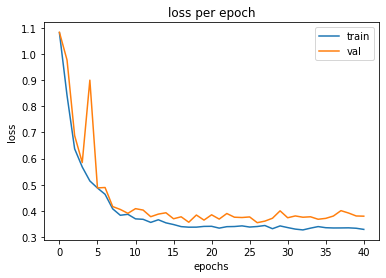

val Loss: 0.3799 Acc: 0.8454

Epoch 41/59
----------


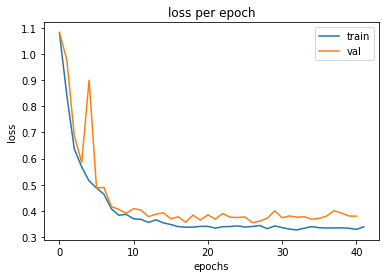

train Loss: 0.3391 Acc: 0.8684


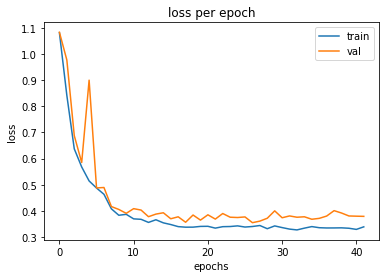

val Loss: 0.3792 Acc: 0.8483

Epoch 42/59
----------


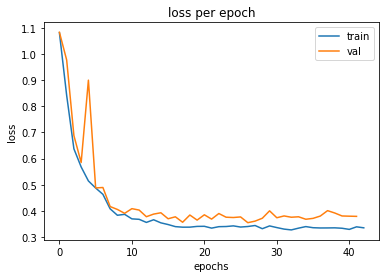

train Loss: 0.3354 Acc: 0.8701


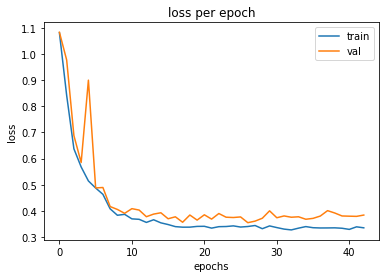

val Loss: 0.3841 Acc: 0.8542

Epoch 43/59
----------


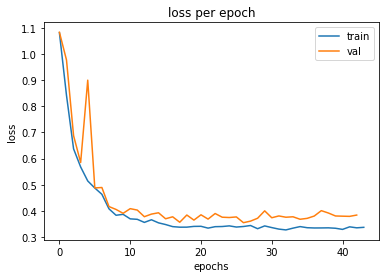

train Loss: 0.3373 Acc: 0.8715


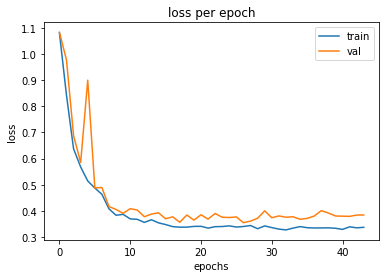

val Loss: 0.3845 Acc: 0.8429

Epoch 44/59
----------


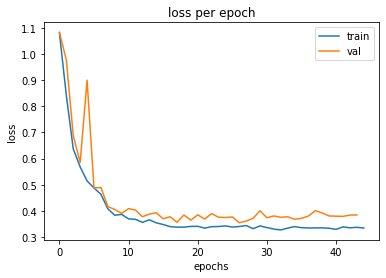

train Loss: 0.3345 Acc: 0.8707


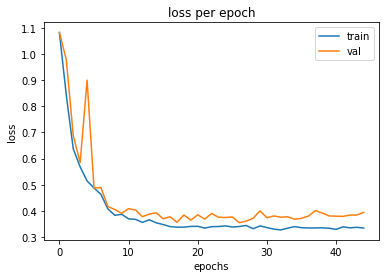

val Loss: 0.3945 Acc: 0.8475

Epoch 45/59
----------


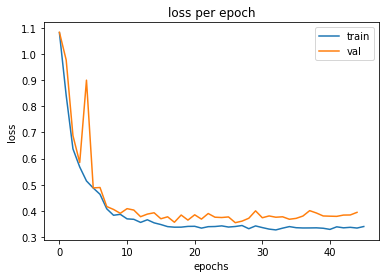

train Loss: 0.3403 Acc: 0.8698


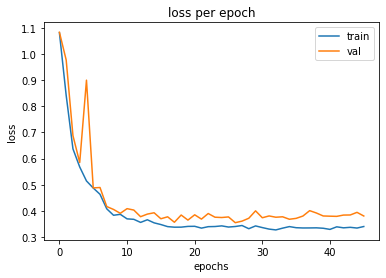

val Loss: 0.3805 Acc: 0.8463

Epoch 46/59
----------


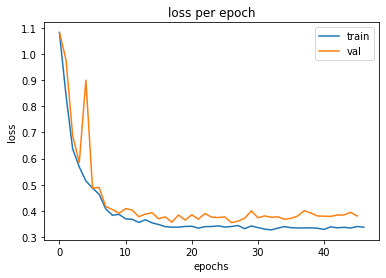

train Loss: 0.3375 Acc: 0.8699


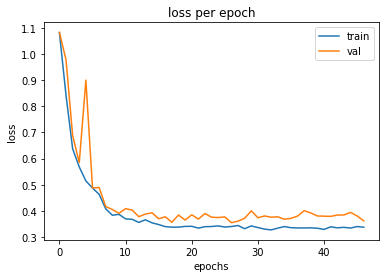

val Loss: 0.3619 Acc: 0.8600

Epoch 47/59
----------


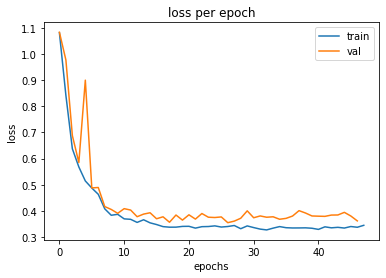

train Loss: 0.3450 Acc: 0.8677


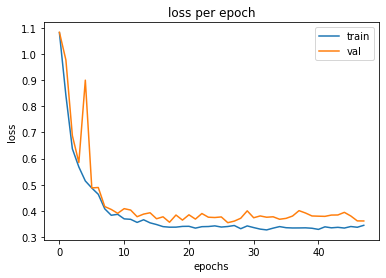

val Loss: 0.3616 Acc: 0.8583

Epoch 48/59
----------


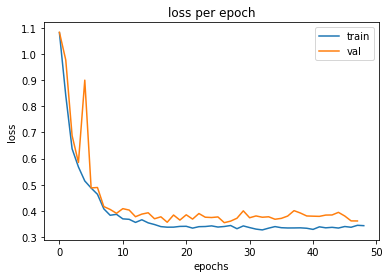

train Loss: 0.3436 Acc: 0.8662


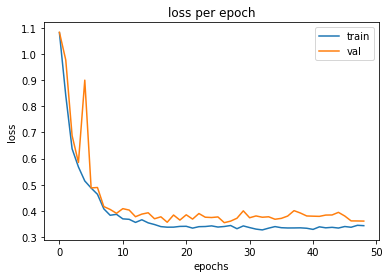

val Loss: 0.3611 Acc: 0.8529

Epoch 49/59
----------


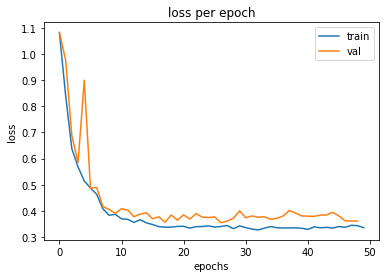

train Loss: 0.3357 Acc: 0.8708


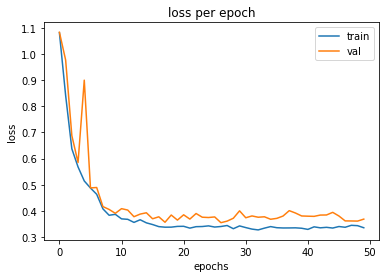

val Loss: 0.3686 Acc: 0.8508

Epoch 50/59
----------


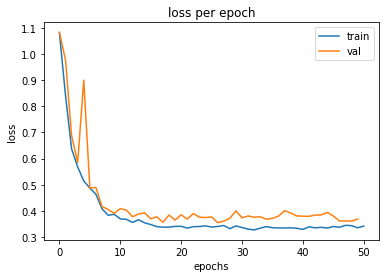

train Loss: 0.3420 Acc: 0.8669


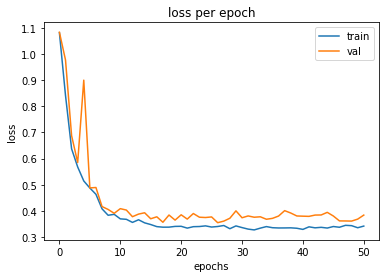

val Loss: 0.3840 Acc: 0.8496

Epoch 51/59
----------


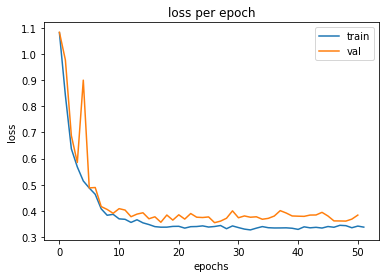

train Loss: 0.3380 Acc: 0.8699


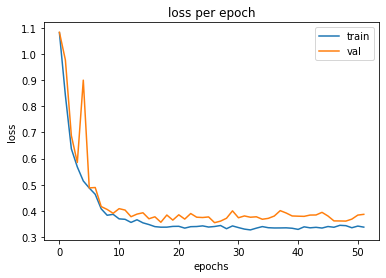

val Loss: 0.3869 Acc: 0.8517

Epoch 52/59
----------


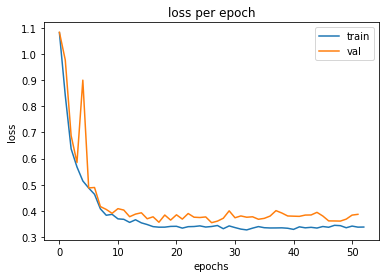

train Loss: 0.3383 Acc: 0.8692


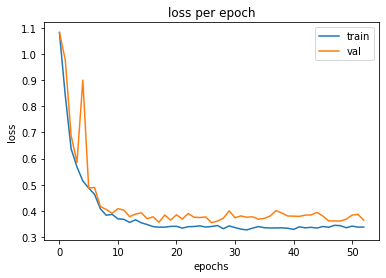

val Loss: 0.3644 Acc: 0.8588

Epoch 53/59
----------


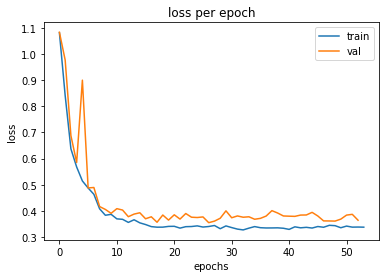

train Loss: 0.3378 Acc: 0.8677


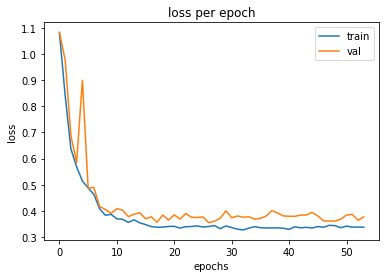

val Loss: 0.3771 Acc: 0.8521

Epoch 54/59
----------


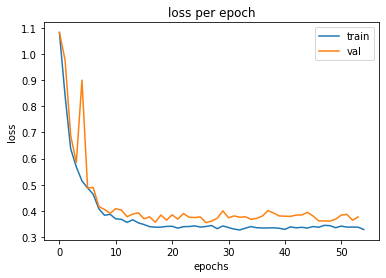

train Loss: 0.3289 Acc: 0.8741


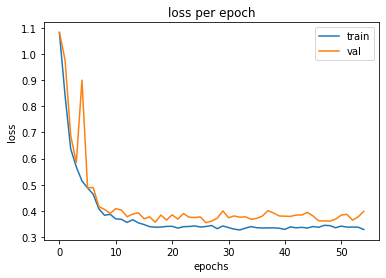

val Loss: 0.3984 Acc: 0.8375

Epoch 55/59
----------


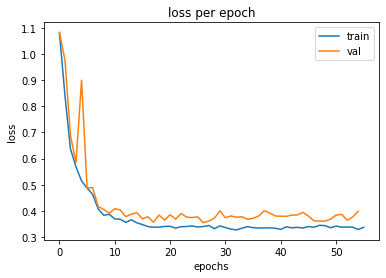

train Loss: 0.3374 Acc: 0.8709


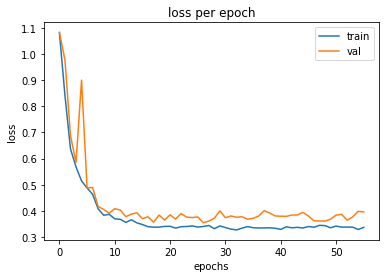

val Loss: 0.3961 Acc: 0.8429

Epoch 56/59
----------


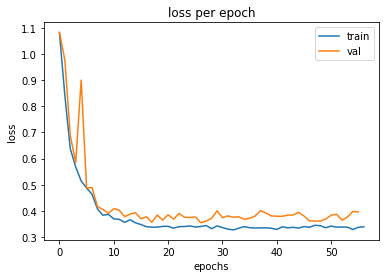

train Loss: 0.3391 Acc: 0.8693


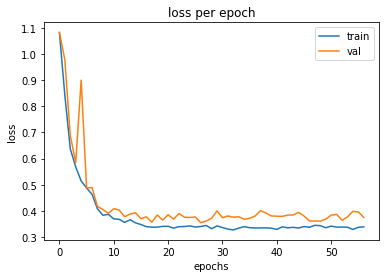

val Loss: 0.3750 Acc: 0.8521

Epoch 57/59
----------


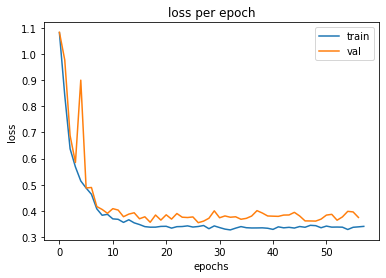

train Loss: 0.3409 Acc: 0.8682


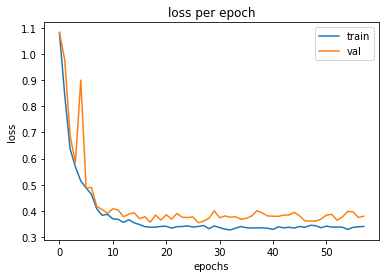

val Loss: 0.3799 Acc: 0.8488

Epoch 58/59
----------


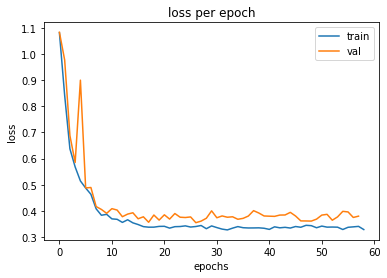

train Loss: 0.3287 Acc: 0.8766


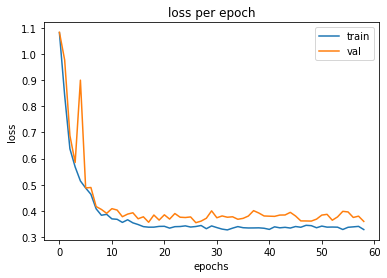

val Loss: 0.3599 Acc: 0.8592

Epoch 59/59
----------


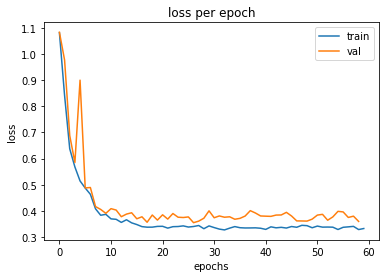

train Loss: 0.3327 Acc: 0.8725


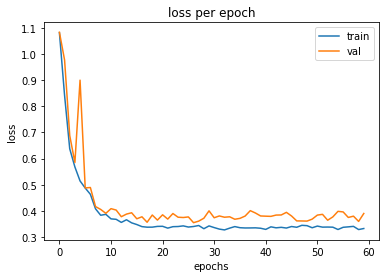

val Loss: 0.3902 Acc: 0.8538

Training complete in 264m 9s
Best val Acc: 0.863750


In [ ]:
model_ft, train_losses, train_accuracies, val_losses, val_accuracies  = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=60)

In [ ]:
os.chdir('/content/drive/Shareddrives/ResNet18_Model_parameters')

In [ ]:
# Present working directory
!pwd

/content/drive/Shareddrives/ResNet18_Model_parameters


In [ ]:
PATH = 'ResNet18_shortened2_retina_Adam_60epochs.pth'

In [ ]:
torch.save(model_ft.state_dict(), PATH)
print('Model Saved!')

Model Saved!


In [ ]:
net = ResNet18()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
net.to(device)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [ ]:
def test_model(model, num_epochs=1):
    model.eval()
    since = time.time()

    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['test']:
            
            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.no_grad():
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
           

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

           
        print()

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))


In [ ]:
test_model = test_model(net)

Epoch 0/0
----------
test Loss: 1.0168 Acc: 0.7412

Testing complete in 0m 17s
Best Test Acc: 0.000000
